# **Associations between aversive learning processes and transdiagnostic psychiatric symptoms revealed by large-scale phenotyping**

---

# Parameter recovery

This notebook checks parameter recoverability for our winning model.

## Imports

In [1]:
import sys
sys.path.insert(0, '../code')
import dill
import re
import matplotlib.pyplot as plt
import numpy as np
import theano.tensor as T
import json
import os
from DMpy import DMModel, Parameter
from DMpy.utils import beta_response_transform
from DMpy.observation import softmax
import pandas as pd
import copy
from learning_models import *
from tqdm import tqdm
import seaborn as sns
import matplotlib
import matplotlib.font_manager as font_manager
from scipy.stats import pearsonr

np.random.seed(123)

# Nice colours
pal = ['#4f4f4f', '#B80044', '#0e79b2']
light_pal =['#9e9e9e', '#e86d9a', '#64abd1']

# Fonts
prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = '#fbfbfb'

## Get data

Used to get task outcomes for simulations

In [2]:
model_data_path = '../Data/modelling_data'
data = pd.read_csv(os.path.join(model_data_path, 'combined_modelling_data.csv'))
data.Response = data.Response

Then get data for just one subject, as the task outcomes are identical and we only need one subject for these simulations

In [3]:
test_data = data[data.Subject == data.Subject.unique()[1]]
test_data.Subject = 1
data['health'] = data['health'].fillna(-999)
data['Response'] = 0

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Set up parameters for simulation

Here we create 500 simulated subjects with parameter values sampled from guassian distrubtions

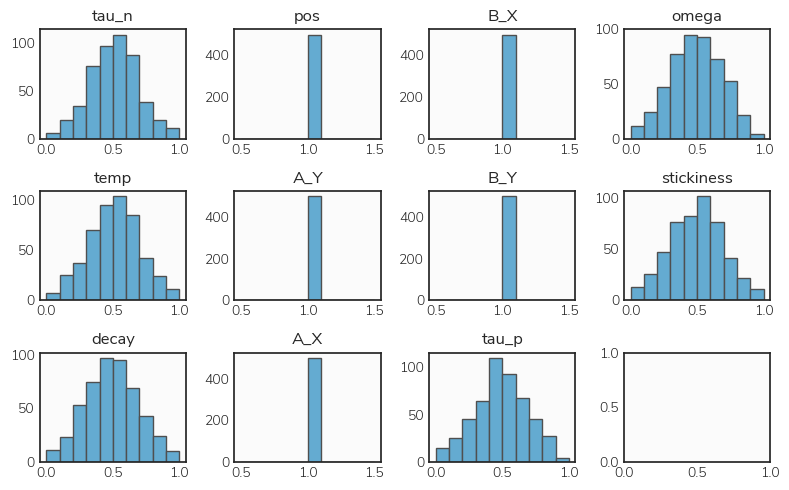

In [4]:
n_subjects = 500

learning_param_dict = dict(pos = np.array([1] * n_subjects),
                A_X = np.array([1] * n_subjects),
                B_X = np.array([1] * n_subjects),
                A_Y = np.array([1] * n_subjects),
                B_Y = np.array([1] * n_subjects),
                decay = np.random.normal(0.5, 0.2, n_subjects),
                tau_p = np.random.normal(0.5, 0.2, n_subjects),
                tau_n = np.random.normal(0.5, 0.2, n_subjects),
                omega = np.random.normal(0.5, 0.2, n_subjects),
                temp = np.random.normal(0.5, 0.2, n_subjects),
                stickiness = np.random.normal(0.5, 0.2, n_subjects))

# Fix any values below 0 or above 1
for k, v in learning_param_dict.iteritems():
    v[v < 0] = 0
    v[v > 1] = 1

# Plot parameter distributions
f, ax = plt.subplots(3, 4, figsize=(8, 5), dpi=100)

for n, k in enumerate(learning_param_dict.keys()):
    ax[n % 3, n / 3].hist(learning_param_dict[k], ec=pal[0], color=light_pal[2])
    ax[n % 3, n / 3].set_title(k)

plt.tight_layout()

## Set up model

In [5]:
# Starting position - not actually used but is required to stop DMpy getting confused
pos = Parameter('pos', 'fixed', mean=0.5, dynamic=True)

# A and B parameters for each location (X and Y) - these are fixed at 1, i.e. equal evidence for both safety and danger
A_X = Parameter('A_X', 'fixed', mean=1, dynamic=True)
B_X = Parameter('B_X', 'fixed', mean=1, dynamic=True)
A_Y = Parameter('A_Y', 'fixed', mean=1, dynamic=True)
B_Y = Parameter('B_Y', 'fixed', mean=1, dynamic=True)
 
# Decay rate (lambda)
decay = Parameter(r'decay', 'normal', lower_bound=0.01, upper_bound=0.9, mean=0.5, variance=100)

# Positive and negative weights for the asymmetric model
tau_p = Parameter(r'tau_p', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100)
tau_n = Parameter(r'tau_n', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100)

# Weighting of the unchosen position, omega
omega = Parameter(r'omega', 'normal', lower_bound=0.01, upper_bound=0.9, mean=0.5, variance=100)

# Softmax temperature
temperature = Parameter(r'temp', 'normal', lower_bound=0, upper_bound=1, mean=0.5, variance=100^2)

# Stickiness parameter
stickiness = Parameter(r'stickiness', 'normal', lower_bound=0.01, upper_bound=1, mean=0.5, variance=100)

# Define model
ALB_sticky_model = DMModel(sticky_ALB, [pos, A_X, B_X, A_Y, B_Y, decay, tau_p, tau_n, omega, temperature, stickiness], None, None,
                               name='ALB sticky', logp_function='beta')

## Simulate data

This takes our model and plugs in the specified parameter values, allowing us to simulate behavioural data from a range of parameter values

In [6]:
simulated, _ = ALB_sticky_model.simulate(test_data[['Outcome', 'Outcome_2']], response_variable='value', model_inputs=['Outcome_2'], learning_parameters=learning_param_dict, combinations=False)

Simulating data from 500 sets of parameter values


c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1105: Warning: Fewer outcome lists than simulated subjects, attempting to use same outcomes for each subject (number of outcome lists = 269, number of subjects = 500
  p_combinations.shape[0]), Warning)
c:\users\toby\onedrive - university college london\dmpy\DMpy\model.py:1155: UserWarning: NaNs present in value
  warnings.warn("NaNs present in {0}".format(r))


Saving simulated results to 


In [7]:
simulated.results.head()

,value,alpha_0,beta_0,alpha_1,beta_1,var_0,var_1,value_0,value_1,o,...,decay_sim,pos_sim,A_Y_sim,A_X_sim,B_X_sim,B_Y_sim,tau_p_sim,omega_sim,stickiness_sim,Response
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.089448,0.073157,0.417304,0.918219,0.0,...,0.282874,1.0,1.0,1.0,1.0,1.0,0.650407,0.811515,0.202372,1.000000
1,0.030742,0.717126,1.001347,1.367533,0.717126,0.084937,0.062724,0.796538,0.745761,0.0,...,0.282874,1.0,1.0,1.0,1.0,1.0,0.650407,0.811515,0.202372,0.030742
2,0.586572,0.514270,1.068326,1.508508,0.514270,0.093310,0.046670,0.539238,0.961691,1.0,...,0.282874,1.0,1.0,1.0,1.0,1.0,0.650407,0.811515,0.202372,0.586572
3,0.051644,0.896611,0.766125,1.732197,0.368796,0.095602,0.037270,0.837696,0.870005,0.0,...,0.282874,1.0,1.0,1.0,1.0,1.0,0.650407,0.811515,0.202372,0.051644
4,0.444583,0.642983,0.899643,1.770019,0.264474,0.088076,0.028910,0.792342,0.904540,0.0,...,0.282874,1.0,1.0,1.0,1.0,1.0,0.650407,0.811515,0.202372,0.444583


## Fit the model

We then fit our model to the simulated data.

> _This is commented out as we'll use results from a previously run fit - it takes a few hours to fit this model so we don't want to do it every time the notebook is run!_

In [8]:
# ALB_sticky_model.fit(simulated.results, model_inputs=['sim_model_input_0'], response_transform=beta_response_transform, 
#           fit_method='variational', fit_kwargs={'n': 40000}, hierarchical=True, plot=False, suppress_table=True, fit_stats=True)

### Save the results to file

In [9]:
# pr_results = ALB_sticky_model.parameter_table.copy()
# pr_sim_values = pd.DataFrame(learning_param_dict)

# pr_results.to_csv('../data/pr_results.csv')
# pr_sim_values.to_csv('../data/pr_sim_values.csv')

### Reload the results

This is just helpful to avoid re-running the model fitting above every time we run the notebook!

In [10]:
pr_results = pd.read_csv('../data/parameter_recovery_table.csv')
pr_sim_values = pd.read_csv('../data/param_recovery_sim_values.csv')

## Plots

First we'll plot the simulated values against the recovered values, and calculate the correlation between them using Pearson $R$

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


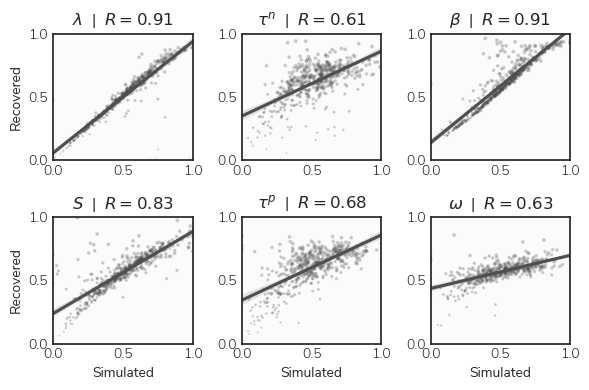

In [11]:
params = ['decay', 'stickiness', 'tau_n', 'tau_p', 'temp', 'omega']
param_names = [r'$\lambda$', r'$S$', r'$\tau^n$', r'$\tau^p$', r'$\beta$', '$\omega$']

f, ax = plt.subplots(2, 3, figsize=(6, 4), dpi=100)

for n, p in enumerate(params):

    r = pearsonr(pr_sim_values[p], pr_results['mean_' + p])[0]
    ax[n % 2, n / 2].set_title(param_names[n] + r'  |  $R = {0}$'.format(np.round(r, 2)))
    sns.regplot(pr_sim_values[p], pr_results['mean_' + p], ax=ax[n % 2, n / 2], color=pal[0], scatter_kws={'alpha': 0.2, 's': pr_results['mean_' + p] * 2 ** 2})

    if n % 2 == 1:
        ax[n % 2, n / 2].set_xlabel("Simulated")
    else:
        ax[n % 2, n / 2].set_xlabel("")
        
    if n / 2 == 0:
        ax[n % 2, n / 2].set_ylabel("Recovered")
    else:
        ax[n % 2, n / 2].set_ylabel("")
    
    ax[n % 2, n / 2].set_xlim(0, 1)
    ax[n % 2, n / 2].set_ylim(0, 1)
    ax[n % 2, n / 2].set_yticks(np.arange(0, 1.1, 0.5))
    ax[n % 2, n / 2].set_xticks(np.arange(0, 1.1, 0.5))

plt.tight_layout()
plt.savefig('../figures/parameter_recovery.svg')

While this isn't perfect, the simulated and recovered values are fairly tightly correlated for most parameters. One exception is $\omega$, but this isn't a parameter we're particularly interested in.

We can then plot the correlation matrix to show correlations between simulated and recovered values for all parameters.

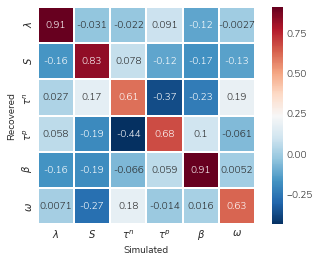

In [12]:
sns.heatmap(np.corrcoef(pr_sim_values[params].T, pr_results[['mean_' + i for i in params]].T)[6:, :6], 
            cmap='RdBu_r', annot=True, square=True, linewidths=1, xticklabels=param_names, yticklabels=param_names)
plt.xlabel('Simulated')
plt.ylabel('Recovered')
plt.savefig('../figures/parameter_recovery_matrix.svg')